# Global Centroid Moment Tensor 3D (GCMT3D)

## The workflow

### Downloading the Data
The first step in the inversion process is downloading data that corresponds to the original solution of Global CMT Catalogue, which is maintained by the Lamont-Doherty Earth Observatory.

To do this we use the Specifically design DataRequest class. We have to define certain parameters before we download the data:

In [12]:
from gcmt3d.data_download.requestBuilder import DataRequest

# Parameters
duration = 3600      # seconds, 1h = 3600s
channels = ['BHZ']   # needs to be a list
locations=['00']     # location 00 is the primary location for most seismometers
starttime_offset=-60  # -60 seconds is 1 min before the earthquakes inverted cmt solution 
resp_format="resp"   # response format
outputdir=""         # specific output directory here left open

# Earthquake and Station parameters
cmt_filename = "./data/eq_010202E/fijiCMT.cmt"
stationlist_filename = "./src/gcmt3d/data_download/resources/stations.txt"

# Create Request Object   
Request = DataRequest.from_file(cmt_filename,
                                stationlist_filename,
                                duration=duration,
                                channels=channels,
                                locations=locations,
                                starttime_offset=starttime_offset,
                                resp_format=resp_format,
                                outputdir=outputdir)

# Download the data using the download method
Request.download()




# Data to ASDF

Since the downloaded data can't simply be used in the `.mseed` format,
the data needs to be converted into a more versatile format. This can 
be done using obspy and pyasdf.

## Import data as streams

In [1]:
import numpy
import pyasdf
from obspy import read, read_inventory
from gcmt3d import CMTSource

# Import event
cmt = CMTSource.from_CMTSOLUTION_file("data/eq_010202E/fijiCMT.cmt")
event_coordinates = (cmt.latitude,cmt.longitude)

# Read Station XML as inventory
inv = read_inventory("data/eq_010202E/station.xml")

# Import traces
stream = read("data/eq_010202E/seismograms/010202E.mseed")

# Remove the responses from the traces using the inventory
stream.remove_response(inventory=inv)

# Detrend the traces linearly
stream.detrend()

# Bandpass filter the traces using a butterworth filter
stream.filter("bandpass",freqmin=0.01, freqmax=1.5)


83 Trace(s) in Stream:

IC.BJT.00.BHZ | 2002-01-02T14:50:39.210044Z - 2002-01-02T15:50:39.160044Z | 20.0 Hz, 72000 samples
...
(81 other traces)
...
IU.YSS.00.BHZ | 2002-01-02T14:50:39.236045Z - 2002-01-02T15:50:39.186045Z | 20.0 Hz, 72000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Now, what we have is a source, an inventory with the station information 
and a stream object containing traces, from which the response has been 
removed and which have been normalized. To get an overview of the recorded
traces the next step is to plot them in a section as a function of distance 
to the earthquake. To do this we need to add either the epicentral distance 
to `stream.trace.stats.distance` or we can add the location to 
`stream.trace.stats.coordinates.latitude` and 
`stream.trace.stats.coordinates.longitude`. This is done by looping through 
the traces and finding the necessary info in the inventory file:


In [2]:
# Adding location to the traces
for st in stream:
    
    # Getting the seed_id to request the specific station location from inventory
    seed_id = st.stats.network + "." + st.stats.station + "." + st.stats.location + "." + st.stats.channel
    
    # Get station coordinates from inventory
    temp = inv.get_coordinates(seed_id)
    
    # Add coordinates to inventory
    st.stats.coordinates = {"latitude": temp["latitude"],
                            "longitude": temp["longitude"]}
    
#     st.stats.coordinates.latitude = temp["latitude"]
#     st.stats.coordinates.longitude = temp["longitude"]
    
    # 
    #     print(st.stats.coordinates.latitude)
    #     print(st.stats.coordinates.longitude)
 

In [3]:
print(stream[0].stats.coordinates.latitude)


40.018299


After adding the coordinates to the traces, we can plot them:

In [4]:
print("Lat/Lon of first trace")
print(stream[0].stats.coordinates.latitude)
print(stream[0].stats.coordinates.longitude)
print("Lat/Lon of event")
print(event_coordinates[0])
print(event_coordinates[1])



Lat/Lon of first trace
40.018299
116.1679
Lat/Lon of event
-17.63
178.84


<IPython.core.display.Javascript object>


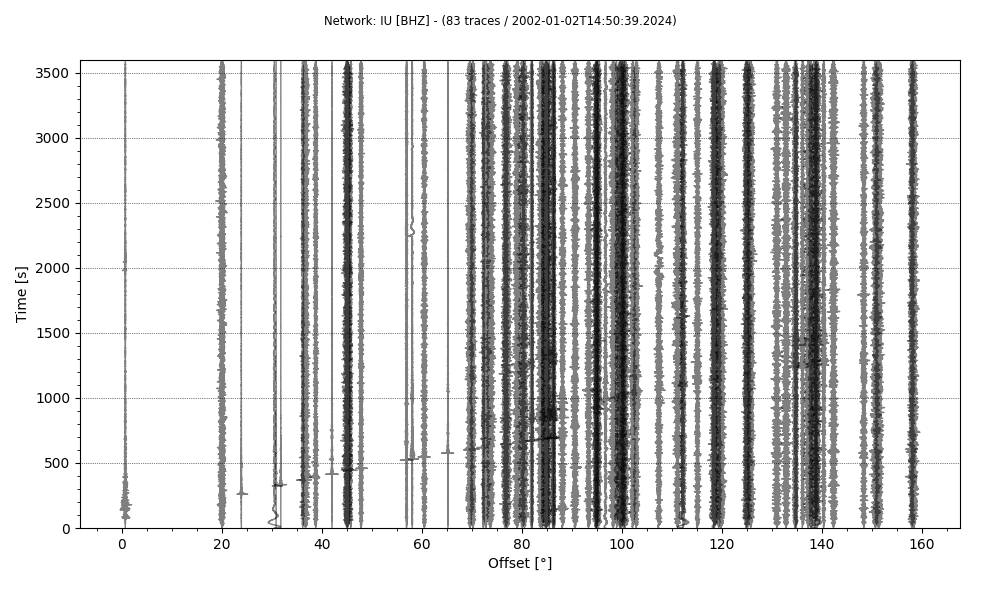

<IPython.core.display.Javascript object>


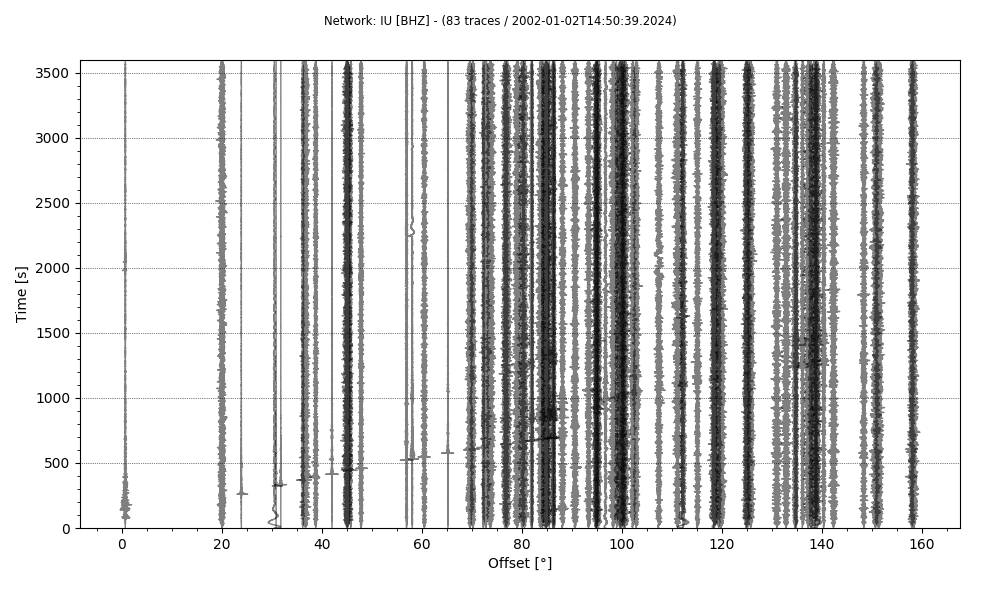

In [5]:
%matplotlib notebook
stream.plot(ev_coord=event_coordinates,type='section',dist_degree=True)

In [6]:
print(stream[0].stats)


         network: IC
         station: BJT
        location: 00
         channel: BHZ
       starttime: 2002-01-02T14:50:39.210044Z
         endtime: 2002-01-02T15:50:39.160044Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72000
           calib: 1.0
         _format: MSEED
     coordinates: AttribDict({'latitude': 40.018299, 'longitude': 116.1679})
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 21, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 7946240})
      processing: ["ObsPy 1.1.1: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x7f7add036cc0>::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)", "ObsPy 1.1.1: detrend(options={}::type='simple')", "ObsPy 1.1.1: filter(options={'freqmin': 0.01, 'freqmax': 1.5}::type='bandpass')"]


## Getting arrival times using the obspy built in TauP package

In [7]:
from obspy.taup import TauPyModel

model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=55,
                                  distance_in_degree=67,phase_list=["P", "PSPSPS"])

print(arrivals)

/home/lsawade/.anaconda3/lib/python3.7/site-packages/pyasdf/asdf_data_set.py:52: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  closure_warn(self, *args, **kwargs)


2 arrivals
	P phase arrival at 647.041 seconds
	PSPSPS phase arrival at 4752.659 seconds
